In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [3]:
DATADIR ='C:\\Users\\Hp\\toyota'


In [4]:
categories =['corolla', 'mehran']

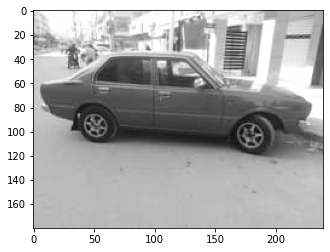

In [5]:
for category in categories:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array,cmap='gray')
        plt.show() 
        break
    break

# Resizing the images

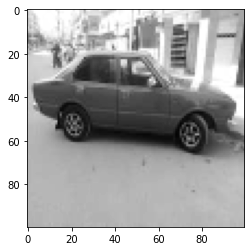

In [6]:
IMG_SIZE = 100

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

# Making the training function

In [7]:
training_data = []

In [8]:
def create_training_data():
    for category in categories:
        path = os.path.join(DATADIR,category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass 

create_training_data()


In [1]:
print(len(training_data))

NameError: name 'training_data' is not defined

# shuffling the data for better training


In [10]:
import random

In [11]:
random.shuffle(training_data)

In [12]:
for sample in training_data[:10]:
    print(sample[1])

1
0
1
0
0
1
0
1
1
0


In [13]:
x =[]
y= []

In [14]:
for features,labels in training_data:
    x.append(features)
    y.append(labels)
    
x = np.array(x).reshape(-1,IMG_SIZE,IMG_SIZE, 1)


In [15]:
import pickle

In [16]:
pickle_out = open("x.pickle","wb")
pickle.dump(x, pickle_out)
pickle_out.close()

In [17]:
pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [18]:
pickle_in = open("x.pickle", "rb")
x = pickle.load(pickle_in)

In [19]:
x[1]

array([[[255],
        [255],
        [255],
        ...,
        [ 73],
        [ 72],
        [ 70]],

       [[255],
        [255],
        [255],
        ...,
        [ 75],
        [ 73],
        [ 72]],

       [[255],
        [255],
        [255],
        ...,
        [ 72],
        [ 70],
        [ 69]],

       ...,

       [[164],
        [152],
        [155],
        ...,
        [ 60],
        [ 75],
        [ 76]],

       [[160],
        [152],
        [155],
        ...,
        [ 66],
        [ 64],
        [ 80]],

       [[148],
        [147],
        [146],
        ...,
        [ 67],
        [ 68],
        [ 74]]], dtype=uint8)

In [20]:
import tensorflow as tf

In [21]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Activation , Flatten, Conv2D, MaxPooling2D

In [23]:
import pickle

In [2]:
x = pickle.load(open('x.pickle','rb'))
y = pickle.load(open('y.pickle','rb'))

NameError: name 'pickle' is not defined

# Bringing all the values in scale of 0-1

In [3]:
x = x/255.0

NameError: name 'x' is not defined

# Preparing the training and Validation data for Mehran and Corolla

In [28]:
batch_size = 32
img_height = 180
img_width = 180

In [29]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATADIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2295 files belonging to 2 classes.
Using 1836 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATADIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

NameError: name 'tf' is not defined

# Identifying the predicted Classes

In [33]:
class_names = train_ds.class_names
print(class_names)

['corolla', 'mehran']


# Visualizing the training dataset

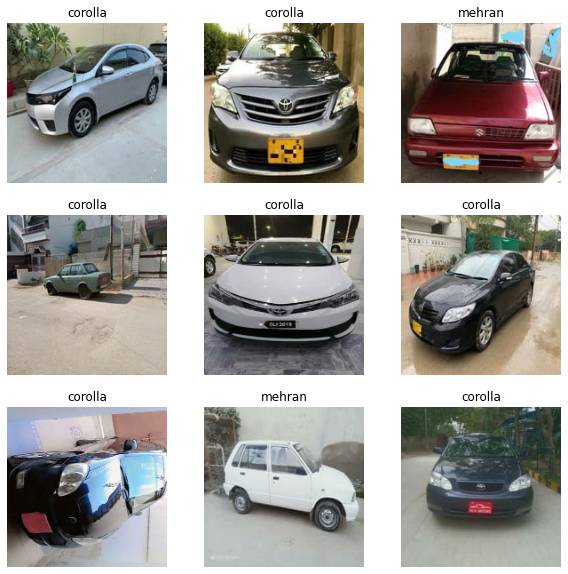

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [37]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


# Auto Tuning Hyper Parameters

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# The RGB channel values are in the [0, 255] range.
# Making it ideal for neural network.

In [54]:
from tensorflow.keras.layers import Rescaling

In [55]:
from tensorflow.keras import layers

In [56]:
normalization_layer = layers.Rescaling(1./255)

In [59]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## CREATING THE MODEL

In [60]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [61]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

# Train the model

In [5]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

NameError: name 'model' is not defined

# Visualizing the loss and Accuracy function

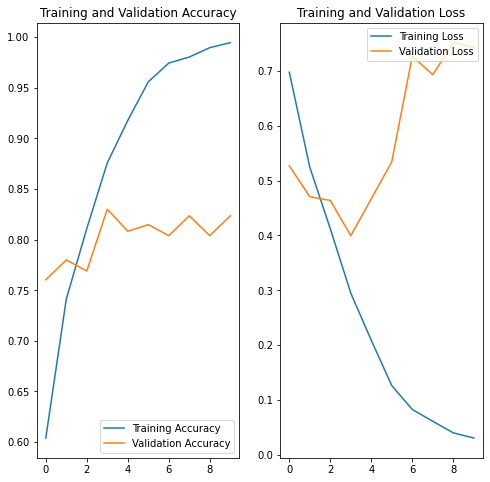

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [65]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [67]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
58/58 [==============================] - 32s 547ms/step - loss: 0.0463 - accuracy: 0.9891 - val_loss: 0.7618 - val_accuracy: 0.8083
Epoch 2/15
58/58 [==============================] - 32s 552ms/step - loss: 0.0261 - accuracy: 0.9924 - val_loss: 1.1292 - val_accuracy: 0.7974
Epoch 3/15
58/58 [==============================] - 32s 548ms/step - loss: 0.0098 - accuracy: 0.9984 - val_loss: 1.1578 - val_accuracy: 0.7865
Epoch 4/15
58/58 [==============================] - 32s 550ms/step - loss: 0.0180 - accuracy: 0.9984 - val_loss: 1.0226 - val_accuracy: 0.8192
Epoch 5/15
58/58 [==============================] - 32s 550ms/step - loss: 0.0096 - accuracy: 0.9984 - val_loss: 1.0806 - val_accuracy: 0.8170
Epoch 6/15
58/58 [==============================] - 32s 554ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 1.2109 - val_accuracy: 0.8126
Epoch 7/15
58/58 [==============================] - 32s 555ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 1.0705 - val_accuracy: 0.8126

## TEST CASE - PREDICTION

Image belongs to corolla with a 100.00 percent confidence.


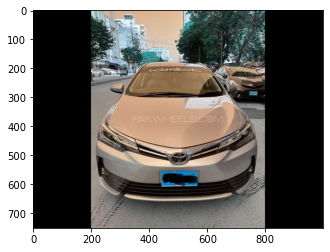

In [85]:

path = 'C:\\Users\\Hp\\Downloads\\c.jpg'
img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))



## Converting image to array:

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

pic = cv2.imread(path)
plt.imshow(pic)
print("Image belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
)